In [2]:
# imports
import pandas as pd

import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from scipy import stats

import matplotlib.pyplot as plt

In [3]:
# set seaborn theme
sns.set_theme(style='ticks', palette='bright')

In [4]:
# load data
df = pd.read_excel("Capital One - Data Set (STEP UP).xlsx")

In [5]:
# filling missing values
df[['REGION', 'OCCUPATION', 'MOBILE_APP_USER', 'CARD_COLOUR']] = df[['REGION', 'OCCUPATION', 'MOBILE_APP_USER', 'CARD_COLOUR']].fillna(method="ffill")
df['AGE'] = df['AGE'].fillna(df['AGE'].mean())

In [6]:
# prep data for categorical regression with one-hot encoding
X = df.drop(["SPEND_M3_TOTAL","CUSTOMER_ID", "PARENT", "REGION"], axis=1)
X['CREDIT_LIMIT'] = X['CREDIT_LIMIT'].astype('category')
y = df["SPEND_M3_TOTAL"]

X = pd.get_dummies(X, drop_first=True)

# split dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# fit the regression model
model = linear_model.LinearRegression()
model = model.fit(X_train, y_train)

In [7]:
# train score
train_score = model.score(X_train, y_train)

In [8]:
# test score
test_score = model.score(X_test, y_test)

In [9]:
coef = pd.DataFrame(zip(X.columns, model.coef_), columns=['variable', 'coefficient'])

A regression model was fitted to the data.

The variables 'PARENT' and 'REGION' were not found to be significant and were consequently dropped from the model.

The regression results used for analysis are as follows.

In [10]:
import statsmodels.api as sm

#add constant to predictor variables
X_train_with_constant = sm.add_constant(X_train)

#fit linear regression model
res = sm.OLS(y_train, X_train_with_constant).fit()

#view model summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         SPEND_M3_TOTAL   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1436.
Date:                Sat, 05 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:25:31   Log-Likelihood:                -40331.
No. Observations:                7500   AIC:                         8.070e+04
Df Residuals:                    7483   BIC:                         8.081e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The fit was evaluated with the following metrics.

In [11]:
# Evaluation metrics
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse, 3))
print("R_squared:", round(r2, 3))

RMSE: 51.077
R_squared: 0.754


With an R-squared of around 0.75, the fit is reasonable.

An RMSE of around 50 means that the value of `SPEND_M3_TOTAL` predicted by the model differs on average from the observed value by around 50 pounds.

---------------

The baseline was taken to be a person that has the characteristics `OCCUPATION_EMPLOYED`,  `CARD_COLOUR_Black`  and `CREDIT_LIMIT_250`, so the regression coefficients in the respective categories are in comparison to these values.

The regressions coefficients are as follows.

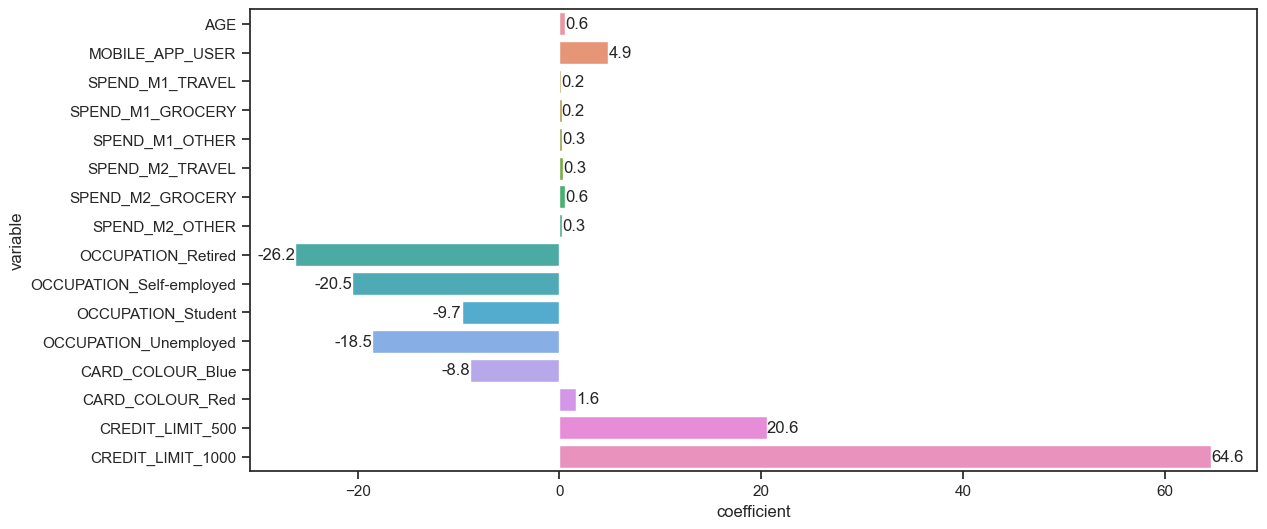

In [12]:
plt.figure(figsize=(13,6))
ax = sns.barplot(coef, y='variable', x='coefficient')
ax.bar_label(ax.containers[0], fmt='%.1f')
plt.show()

## The insights from regression

#### The total spend in month 3 is expected to increase by

* 0.6 pounds *for each year* of a person's **age**

##### What does this mean?

Age is predictive of more spending. For example, a 60 year old is expected to spend on average 18 pounds more than a 30 year old in month 3.

##### What can we do?

While the difference in spending for older and younger people is not very large, we can consider focusing our advertising efforts on avenues more likely to reach younger people (internet and social media vs tv and radio).

----------------------

#### The total spend in month 3 is expected to increase by

* 0.2 pounds *for each pound* spent on **travel in month 1**
* 0.2 pounds *for each pound* spent on **grocery in month 1**
* 0.3 pounds *for each pound* spent on **other in month 1**

* 0.3 pounds *for each pound* spent on **travel in month 2**
* 0.6 pounds *for each pound* spent on **grocery in month 2**
* 0.3 pounds *for each pound* spent on **other in month 2**

##### What does this mean?

Spending in previous months is predicitive of more spending in month 3. This effect seems to be stronger for more recent months. This isn't neccessarily something that we can use for business strategy.

-------------------------------

#### Compared to a non-mobile app user

* A **mobile app user** is expected to spend on average 4.9 pounds more in month 3

##### What does this mean?

Mobile app users spend on average more in month 3.

##### What can we do?

Encourage customers to install the app. As an example, create a lottery system that each month rewards new sign-ups with 50 pounds.

-------------------

#### Compared to a person that's employed

* A person that's **retired** is expected to spend on average 26.2 pounds *less* in month 3
* A person that's **self-employed** is expected to spend on average 20.5 pounds *less* in month 3
* A person that's a **student** is expected to spend on average 9.7 pounds *less* in month 3
* A person that's **unemployed** is expected to spend on average 18.5 pounds *less* in month 3

##### What does this mean?

Employed customers tend to spend the most, while retired and self-employed customers tend to spend the least. Interestingly, the spending of students and unemployed customers lies somewhere in the middle.

#### What can we do?

Create separate ad campaigns targetting specifically retired and self-empoyed customers.

Encourage (by email, or notification on the app) employed customers to submit customer-satisfaction surveys rating their experience with the company and sharing their feedback.

-----------------

#### Compared to a person with a black card

* A person with a **blue** card is expected to spend on average 8.8 pounds *less* in month 3
* A person with a **red** card is expected to spend on average 1.6 pounds more in month 3


##### What does this mean?

It appears that customer's with blue cards spend less, while customers with black and red cards spend about the same. The idea that card color on it's own influences spending does not seem to be reasonable. We can investigate if card color is tied, for example, to credit limit.

In [69]:
print('Among black cards')
print(f"a propotion of {len(df[(df['CARD_COLOUR']=='Black') & (df['CREDIT_LIMIT']==250)]) / len(df[(df['CARD_COLOUR']=='Black')]):0f} has a credit limit of 250")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Black') & (df['CREDIT_LIMIT']==500)]) / len(df[(df['CARD_COLOUR']=='Black')]):0f} has a credit limit of 500")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Black') & (df['CREDIT_LIMIT']==1000)]) / len(df[(df['CARD_COLOUR']=='Black')]):0f} has a credit limit of 1000.")

print('Among blue cards')
print(f"a propotion of {len(df[(df['CARD_COLOUR']=='Blue') & (df['CREDIT_LIMIT']==250)]) / len(df[(df['CARD_COLOUR']=='Blue')]):0f} has a credit limit of 250")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Blue') & (df['CREDIT_LIMIT']==500)]) / len(df[(df['CARD_COLOUR']=='Blue')]):0f} has a credit limit of 500")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Blue') & (df['CREDIT_LIMIT']==1000)]) / len(df[(df['CARD_COLOUR']=='Blue')]):0f} has a credit limit of 1000.")

print('Among red cards')
print(f"a propotion of {len(df[(df['CARD_COLOUR']=='Red') & (df['CREDIT_LIMIT']==250)]) / len(df[(df['CARD_COLOUR']=='Red')]):0f} has a credit limit of 250")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Red') & (df['CREDIT_LIMIT']==500)]) / len(df[(df['CARD_COLOUR']=='Red')]):0f} has a credit limit of 500")
print(f"a proportion of {len(df[(df['CARD_COLOUR']=='Red') & (df['CREDIT_LIMIT']==1000)]) / len(df[(df['CARD_COLOUR']=='Red')]):0f} has a credit limit of 1000.")

Among black cards
a propotion of 0.518375 has a credit limit of 250
a proportion of 0.300636 has a credit limit of 500
a proportion of 0.180989 has a credit limit of 1000.
Among blue cards
a propotion of 0.540123 has a credit limit of 250
a proportion of 0.308642 has a credit limit of 500
a proportion of 0.151235 has a credit limit of 1000.
Among red cards
a propotion of 0.509137 has a credit limit of 250
a proportion of 0.304978 has a credit limit of 500
a proportion of 0.185885 has a credit limit of 1000.


It does seem that among blue card owners there is more customers with a credit limit of 250 and less customers with a credit limit of 1000. That might at least partially explain why blue card owners are expected to spend less.

---------------------------

#### Compared to a person with a credit limit of 250
* A person with a **credit limit of 500** is expected to spend on average 20.6 pounds more in month 3
* A person with a **credit limit of 1000** is expected to spend on average 64.6 pounds more in month 3

##### What does this mean?

This is perphaps an unsurprising result - people with higher credit limits spend more on their credit cards. This, of course, does not mean that raising all customer's credit limits is a good idea.

##### What can we do?

Periodically review credit limits and notify customer's if they are eligible for a credit limit increase.